In [ ]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 28.3 MB/s eta 0:00:00


In [ ]:
# Mount to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
import os

sys.path.append('/content/drive/MyDrive/Plagiarism-Detection-System/src')

# Import classes from files
from model import SiameseNet
from system import PlagiarismDetectionSystem
from dataset import TripletDataset, triplet_collate_fn

In [ ]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import lightning as L
from torch.utils.data import DataLoader, Dataset, random_split
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
from typing import List, Tuple, Dict, Any, Optional

config = {
    "train_split": 0.95,
    "train_batch_size": 16,
    "dataloader_num_workers": 0,
    "max_epochs": 20,
    "check_val_every_n_epoch": 2,
    "train_classifier_gap": None,
    "siamese_emb_dim": 128,
    "log_every_n_steps": 1
}

EMBEDDINGS_DIR = "/content/drive/MyDrive/Plagiarism-Detection-System/data/mert_embeddings"

In [ ]:

PRETRAINED_MODEL_PATH = "/content/drive/MyDrive/Plagiarism-Detection-System/models/model_accuracy74/best-acc-epoch=15.ckpt"

def run_continued_training():
    if not os.path.exists(EMBEDDINGS_DIR):
        print(f"Error: Δεν βρέθηκε ο φάκελος data: {EMBEDDINGS_DIR}")
        return

    # Setup DataModule
    data_module = MERTDataModule(config, EMBEDDINGS_DIR)

    # Load Pretrained model
    if os.path.exists(PRETRAINED_MODEL_PATH):
        print(f"Loading Pre-trained Model from: {PRETRAINED_MODEL_PATH}")
        model = PlagiarismDetectionSystem.load_from_checkpoint(PRETRAINED_MODEL_PATH, config=config)
    else:
        print("Warning: No checkpoint found. Training model from the start.")
        model = PlagiarismDetectionSystem(config=config)

    # Callbacks & Logger
    logger = CSVLogger("logs", name="melodysim_run")

    latest_ckpt = ModelCheckpoint(
        dirpath="checkpoints_continued",
        filename="latest_model_continued",
        save_last=True,
        verbose=True
    )
    min_loss_ckpt = ModelCheckpoint(
        monitor="val_triplet_loss",
        dirpath="checkpoints_continued",
        filename="best_model_continued-{epoch}",
        save_top_k=1,
        mode="min",
        verbose=True
    )

    trainer = L.Trainer(
        max_epochs=config["max_epochs"],
        check_val_every_n_epoch=config["check_val_every_n_epoch"],
        callbacks=[latest_ckpt, min_loss_ckpt],
        accelerator="auto",
        devices=1,
        logger=logger,
        log_every_n_steps=config["log_every_n_steps"]
    )

    print("Resuming Training (Fine-Tuning)...")

    # Training
    trainer.fit(model, datamodule=data_module)
    print("✅ Continued Training Finished!")

if __name__ == "__main__":
    run_continued_training()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting Training...
[Dataset] Loaded 158 embedding tracks.


┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name                     ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ siamese_net              │ SiameseNet        │  7.8 M │ train │     0 │
│ 1 │ classifier               │ Sequential        │ 33.2 K │ train │     0 │
│ 2 │ criterion_triplet        │ TripletMarginLoss │      0 │ train │     0 │
│ 3 │ criterion_classification │ BCEWithLogitsLoss │      0 │ train │     0 │
│ 4 │ audio_model              │ MERTModel         │ 94.4 M │ eval  │     0 │
└───┴──────────────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 102 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 102 M                                                                                                
Total estimated model params size (MB): 408                                                                        
Modules in train mode: 29                                                                                          
Modules in eval mode: 220                                                                                          
Total FLOPs: 0

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:534: Found 220 module(s) in eval mode 
at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can 
ignore this warning.

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


✅ Training Finished!


Loading metrics from: logs/melodysim_run/version_1/metrics.csv


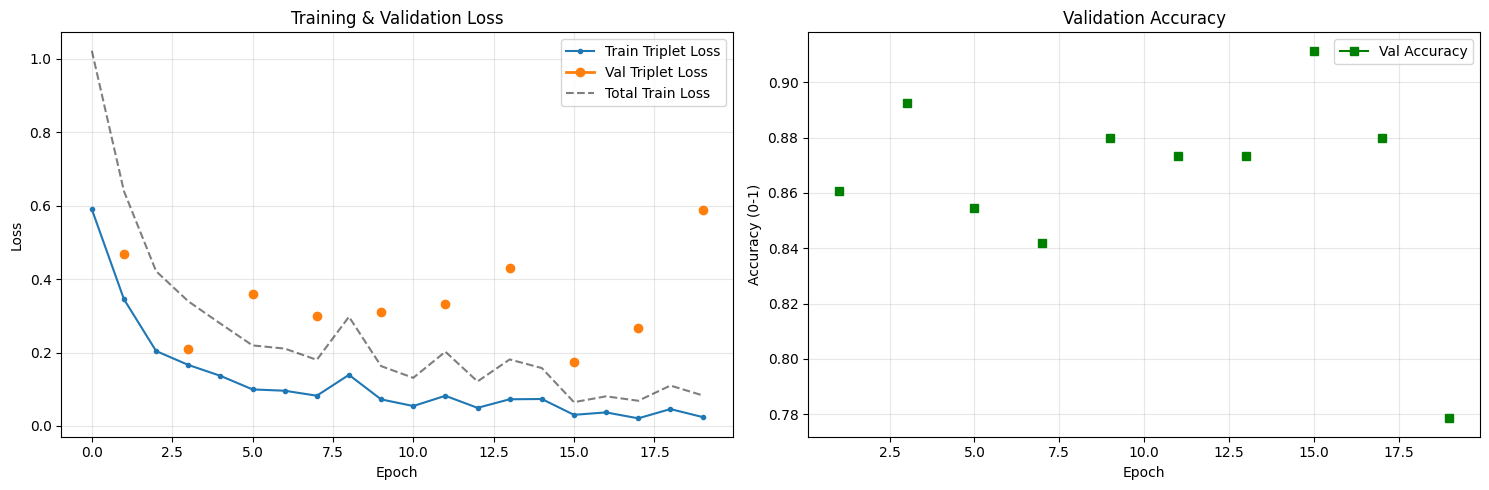

Final Val Loss: 0.5890
Final Val Acc:  77.85%


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_results():
    log_dir = "logs/melodysim_run"

    # Last version
    if not os.path.exists(log_dir):
        print("Νο logs found.")
        return

    versions = sorted([d for d in os.listdir(log_dir) if d.startswith("version_")],
                      key=lambda x: int(x.split('_')[1]))

    if not versions:
        print("No versions found.")
        return

    latest_version = versions[-1]
    metrics_path = os.path.join(log_dir, latest_version, "metrics.csv")
    print(f"Loading metrics from: {metrics_path}")

    try:
        metrics = pd.read_csv(metrics_path)

        # Group by epoch to handle multiple steps per epoch
        metrics = metrics.groupby("epoch").mean()

        plt.figure(figsize=(15, 5))

        # Loss Plot
        plt.subplot(1, 2, 1)
        if 'triplet_loss' in metrics.columns:
            plt.plot(metrics.index, metrics['triplet_loss'], label='Train Triplet Loss', marker='.')
        if 'val_triplet_loss' in metrics.columns:
            plt.plot(metrics.index, metrics['val_triplet_loss'], label='Val Triplet Loss', marker='o', linewidth=2)
        if 'total_loss' in metrics.columns:
            plt.plot(metrics.index, metrics['total_loss'], label='Total Train Loss', linestyle='--', color='black', alpha=0.5)

        plt.title('Training & Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True, alpha=0.3)
        plt.legend()

        # Accuracy Plot (Αν υπάρχει validation accuracy)
        plt.subplot(1, 2, 2)
        if 'val_accuracy' in metrics.columns:
            plt.plot(metrics.index, metrics['val_accuracy'], label='Val Accuracy', color='green', marker='s')
            plt.title('Validation Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy (0-1)')
            plt.grid(True, alpha=0.3)
            plt.legend()
        else:
            plt.text(0.5, 0.5, 'No Accuracy Metric Logged', ha='center')

        plt.tight_layout()
        plt.show()

        print(f"Final Val Loss: {metrics['val_triplet_loss'].iloc[-1]:.4f}" if 'val_triplet_loss' in metrics else "")
        print(f"Final Val Acc:  {metrics['val_accuracy'].iloc[-1]:.2%}" if 'val_accuracy' in metrics else "")

    except Exception as e:
        print(f"Error plotting: {e}")

plot_results()

In [ ]:
import torch
import numpy as np
import os
import random
from sklearn import metrics
from tqdm import tqdm

config = {
    "siamese_emb_dim": 128,
    "train_classifier_gap": None
}
EMBEDDINGS_DIR = "/content/drive/MyDrive/Plagiarism-Detection-System/data/mert_embeddings"

def calibration_evaluation():
    print("Starting Automatic Calibration...")

    # Load Model
    checkpoint_path = "/content/logs/melodysim_run/version_1/checkpoints/best-acc-epoch=15.ckpt"
    if not os.path.exists(checkpoint_path):
        checkpoint_path = [f for f in os.listdir("checkpoints") if f.endswith(".ckpt")][-1]
        checkpoint_path = os.path.join("checkpoints", checkpoint_path)

    print(f"Loading: {checkpoint_path}")
    model = PlagiarismDetectionSystem.load_from_checkpoint(checkpoint_path, config=config)
    model.eval().cuda()

    # Load Data
    track_files = sorted([f for f in os.listdir(EMBEDDINGS_DIR) if f.endswith('.npy')])
    try:
        track_files.sort(key=lambda x: int(x.replace('pair_', '').replace('.npy', '')))
    except:
        pass

    all_track_data = []
    for f in track_files:
        path = os.path.join(EMBEDDINGS_DIR, f)
        all_track_data.append(np.load(path))

    # Create Pairs (Balanced)
    positive_pairs = []
    negative_pairs = []
    num_tracks = len(all_track_data)

    for i in range(num_tracks):
        if all_track_data[i].shape[0] >= 2:
            positive_pairs.append((i, 0, i, 1))

    valid_indices = [i for i in range(num_tracks) if all_track_data[i].shape[0] >= 1]
    while len(negative_pairs) < len(positive_pairs):
        idx1 = random.choice(valid_indices)
        idx2 = random.choice(valid_indices)
        if idx1 != idx2:
            negative_pairs.append((idx1, 0, idx2, 0))

    all_pairs = positive_pairs + negative_pairs
    all_labels = [1] * len(positive_pairs) + [0] * len(negative_pairs)

    print(f"Evaluating on {len(all_pairs)} pairs...")

    # Pre-calculate Similarity Matrices
    all_sim_matrices = []

    print("Computing Similarity Matrices...")
    for t1, v1, t2, v2 in tqdm(all_pairs):
        seg1 = all_track_data[t1][v1]
        seg2 = all_track_data[t2][v2]

        # Prepare inputs
        def prep(x):
            t = torch.from_numpy(x).float().cuda()
            if t.ndim == 4: t = t.permute(0, 1, 3, 2)
            B, L, F, T = t.shape
            return t.reshape(B, L*F, T)

        input1 = prep(seg1)
        input2 = prep(seg2)

        N1 = input1.shape[0]
        N2 = input2.shape[0]
        sim_matrix = torch.zeros(N1, N2)

        with torch.no_grad():
            for i in range(N1):
                row_in = input1[i].unsqueeze(0).repeat(N2, 1, 1)
                # 1 - sigmoid -> Similarity Score
                scores = 1.0 - model._inference_step(row_in, input2)
                sim_matrix[i, :] = scores.cpu()

        all_sim_matrices.append(sim_matrix)

    # Grid Search for Best Thresholds
    print("\nTuning Thresholds...")
    best_acc = 0
    best_f1 = 0
    best_params = (0, 0)
    best_preds = []

    prop_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
    dec_thresholds = [0.6, 0.7, 0.8, 0.9, 0.95, 0.98]

    for prop_t in prop_thresholds:
        for dec_t in dec_thresholds:
            curr_preds = []
            for sim_mat in all_sim_matrices:
                #  Aggregate_decision_matrix
                decision_matrix = sim_mat > dec_t
                N1, N2 = decision_matrix.shape
                row_sum = decision_matrix.sum(dim=1)
                col_sum = decision_matrix.sum(dim=0)

                plag1 = (row_sum >= 1).sum()
                plag2 = (col_sum >= 1).sum()

                if plag1 > prop_t * N1 and plag2 > prop_t * N2:
                    curr_preds.append(1)
                else:
                    curr_preds.append(0)

            acc = metrics.accuracy_score(all_labels, curr_preds)
            f1 = metrics.f1_score(all_labels, curr_preds)

            if acc > best_acc:
                best_acc = acc
                best_f1 = f1
                best_params = (prop_t, dec_t)
                best_preds = curr_preds

    # Final Report
    print("\n" + "="*40)
    print(f"BEST CALIBRATED RESULT")
    print(f"Best Parameters: Proportion={best_params[0]}, Similarity={best_params[1]}")
    print("="*40)
    print(metrics.classification_report(all_labels, best_preds, target_names=["Different", "Similar/Plagiarism"]))
    print("-" * 40)
    print(f"✅ Max Accuracy: {best_acc:.2%}")
    print(f"Confusion Matrix:\n{metrics.confusion_matrix(all_labels, best_preds)}")

calibration_evaluation()

🚀 Starting Automatic Calibration...
📥 Loading: /content/logs/melodysim_run/version_1/checkpoints/best-acc-epoch=15.ckpt
⚖️ Evaluating on 286 pairs...
Computing Similarity Matrices...


100%|██████████| 286/286 [02:19<00:00,  2.06it/s]



🔍 Tuning Thresholds...

🏆 BEST CALIBRATED RESULT
⚙️ Best Parameters: Proportion=0.4, Similarity=0.95
                    precision    recall  f1-score   support

         Different       1.00      0.48      0.64       143
Similar/Plagiarism       0.66      1.00      0.79       143

          accuracy                           0.74       286
         macro avg       0.83      0.74      0.72       286
      weighted avg       0.83      0.74      0.72       286

----------------------------------------
✅ Max Accuracy: 73.78%
Confusion Matrix:
[[ 68  75]
 [  0 143]]


Generating t-SNE from: logs/melodysim_run/version_1/checkpoints/best-acc-epoch=15.ckpt
Loading 100 pairs...
Computing t-SNE...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


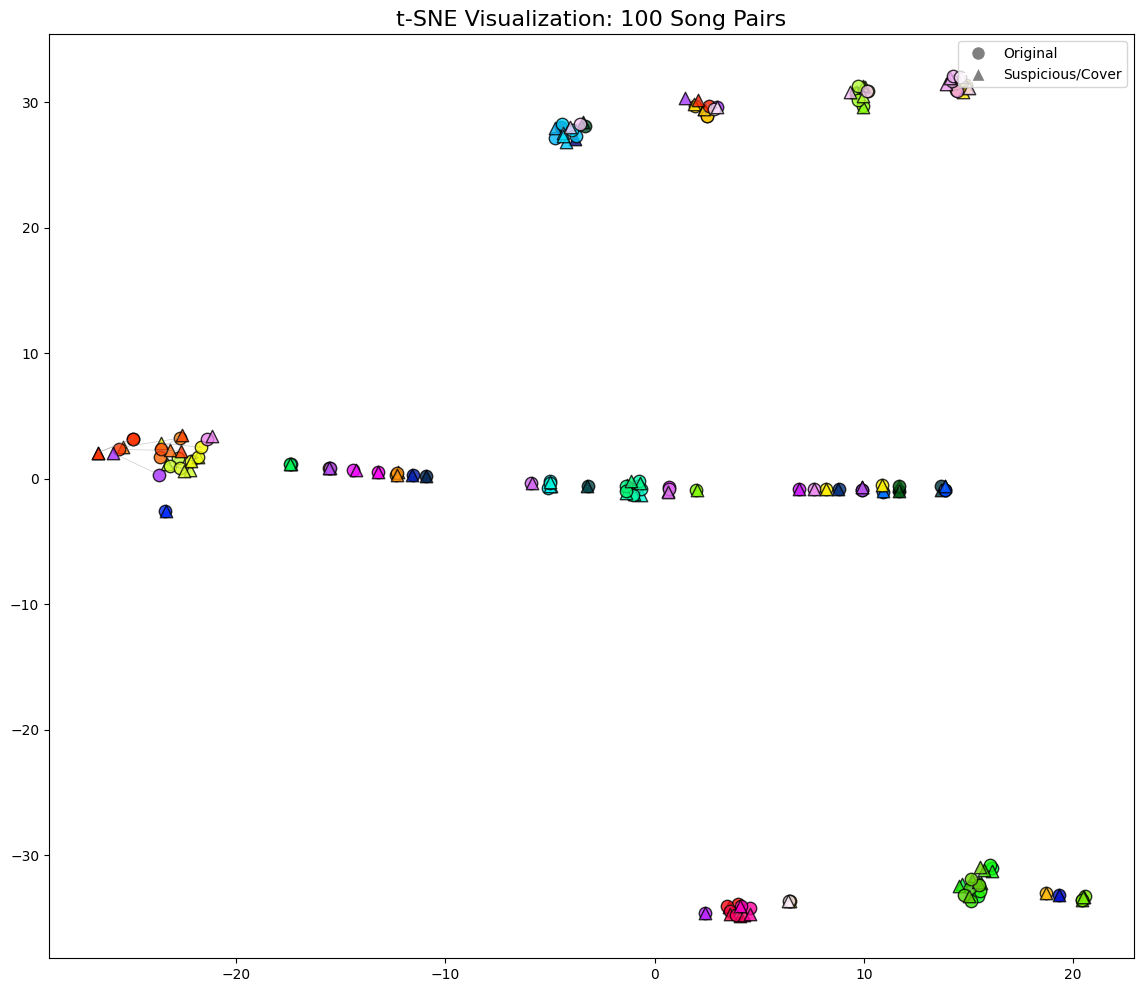

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import glob
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os
import random

EMBEDDINGS_DIR = "/content/drive/MyDrive/Plagiarism-Detection-System/data/mert_embeddings"
NUM_PAIRS = 100
system_config = {
    "siamese_emb_dim": 128,
    "train_classifier_gap": 10
}

class TripletDatasetSorted(Dataset):
    def __init__(self, tracks_dir, length_mult=1):
        self.tracks_dir = tracks_dir
        files = [f for f in os.listdir(tracks_dir) if f.endswith('.npy')]
        try:
            files.sort(key=lambda x: int(x.replace('pair_', '').replace('.npy', '')))
        except ValueError:
            files.sort()
        self.files = files
        self.length_mult = length_mult

    def __len__(self): return len(self.files) * self.length_mult

    def __getitem__(self, idx):
        try:
            idx = idx % len(self.files)
            data = np.load(os.path.join(self.tracks_dir, self.files[idx]))
            if data.shape[0] < 2: return self.__getitem__(random.randint(0, len(self.files)-1))

            # Anchor & Positive
            a_ver = random.randint(0, data.shape[0]-1)
            p_ver = random.choice([i for i in range(data.shape[0]) if i != a_ver])
            seg = random.randint(0, data.shape[1]-1)

            def proc(x):
                t = torch.from_numpy(x).float()
                if t.ndim == 3: t = t.permute(0, 2, 1)
                return t.reshape(-1, t.shape[-1])

            return proc(data[a_ver, seg]), proc(data[p_ver, seg]), proc(data[a_ver, seg])
        except:
            return self.__getitem__(random.randint(0, len(self.files)-1))

def triplet_collate_fn(batch):
    anchors, positives, _ = zip(*batch)
    max_len = max([x.shape[-1] for x in anchors + positives])
    def pad(l): return torch.stack([F.pad(t, (0, max_len - t.shape[-1])) for t in l])
    return pad(anchors), pad(positives), pad(anchors)

def visualize_embeddings_50():
    list_of_files = glob.glob('logs/melodysim_run/*/checkpoints/*.ckpt')

    # Fallback
    if not list_of_files:
        list_of_files = glob.glob('checkpoints/*.ckpt')

    if not list_of_files:
        print("Δεν βρέθηκε checkpoint.")
        return

    latest_ckpt = max(list_of_files, key=os.path.getctime)
    print(f"Generating t-SNE from: {latest_ckpt}")

    model = PlagiarismDetectionSystem.load_from_checkpoint(latest_ckpt, config=system_config)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    dataset = TripletDatasetSorted(EMBEDDINGS_DIR, length_mult=1)
    loader = DataLoader(dataset, batch_size=NUM_PAIRS, collate_fn=triplet_collate_fn, shuffle=False)

    print(f"Loading {NUM_PAIRS} pairs...")
    batch = next(iter(loader))
    anchors, positives, _ = [b.to(device) for b in batch]

    with torch.no_grad():
        emb_anchor = model.siamese_net(anchors).cpu().numpy()
        emb_pos = model.siamese_net(positives).cpu().numpy()

    combined = []
    colors = []
    cmap = plt.get_cmap('gist_ncar')

    for i in range(len(anchors)):
        combined.append(emb_anchor[i])
        combined.append(emb_pos[i])
        colors.append(cmap(i / NUM_PAIRS))
        colors.append(cmap(i / NUM_PAIRS))

    combined = np.array(combined)

    print("Computing t-SNE...")
    tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='pca', learning_rate=200, n_iter=1000)
    reduced = tsne.fit_transform(combined)

    plt.figure(figsize=(14, 12))
    for i in range(0, len(combined), 2):
        p1 = reduced[i]
        p2 = reduced[i+1]
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='gray', linewidth=0.5, alpha=0.4)
        plt.scatter(p1[0], p1[1], color=colors[i], marker='o', s=80, edgecolors='k', alpha=0.8)
        plt.scatter(p2[0], p2[1], color=colors[i], marker='^', s=80, edgecolors='k', alpha=0.8)

    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Original'),
        Line2D([0], [0], marker='^', color='w', markerfacecolor='gray', markersize=10, label='Suspicious/Cover'),
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    plt.title(f"t-SNE Visualization: {NUM_PAIRS} Song Pairs", fontsize=16)
    plt.savefig("thesis_tsne.png", dpi=300, bbox_inches='tight')
    plt.show()

visualize_embeddings_50()

🔍 Checking Distance Matrix Numerically...
Loading: logs/melodysim_run/version_1/checkpoints/best-acc-epoch=15.ckpt

Distance Matrix:
            Cover 1     Cover 2     Cover 3     Cover 4     Cover 5  \
Orig 1     2.950000  140.059998   66.480003  176.509995   59.400002   
Orig 2   139.750000    0.710000   73.629997   36.549999   80.730003   
Orig 3    65.989998   73.800003    1.470000  110.230003    7.050000   
Orig 4   176.330002   36.599998  110.220001    0.790000  117.320000   
Orig 5    58.799999   81.010002    7.570000  117.430000    1.680000   
Orig 6   121.129997  260.859985  187.220001  297.320007  180.130005   
Orig 7    15.060000  154.350006   80.750000  190.830002   73.680000   
Orig 8    88.180000   51.730000   22.150000   88.110001   29.219999   
Orig 9    29.580000  110.330002   36.759998  146.800003   29.709999   
Orig 10  102.830002  242.509995  168.910004  278.980011  161.820007   

            Cover 6     Cover 7     Cover 8     Cover 9    Cover 10  
Orig 1   120.94

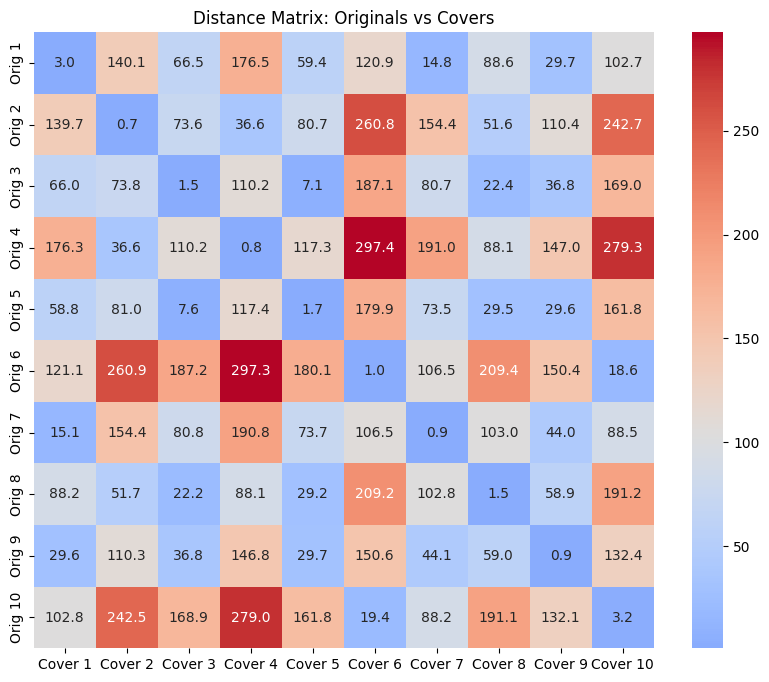

In [ ]:
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
from torch.utils.data import DataLoader

def check_matrix_numerically():
    print("🔍 Checking Distance Matrix Numerically...")

    list_of_files = glob.glob('logs/melodysim_run/*/checkpoints/*.ckpt')
    if not list_of_files:
        list_of_files = glob.glob('checkpoints/*.ckpt')

    if not list_of_files:
        print("Νο checkpoint found.")
        return

    latest_ckpt = max(list_of_files, key=os.path.getctime)
    print(f"Loading: {latest_ckpt}")

    model = PlagiarismDetectionSystem.load_from_checkpoint(latest_ckpt, config=system_config)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    # Χρήση του TripletDatasetSorted για να είμαστε σίγουροι ότι παίρνουμε έγκυρα ζευγάρια
    dataset = TripletDatasetSorted(EMBEDDINGS_DIR, length_mult=1)
    loader = DataLoader(dataset, batch_size=10, collate_fn=triplet_collate_fn, shuffle=True)

    batch = next(iter(loader))
    anchors, positives, _ = [b.to(device) for b in batch]

    with torch.no_grad():
        emb_anchor = model.siamese_net(anchors)
        emb_pos = model.siamese_net(positives)
        dists = torch.cdist(emb_anchor, emb_pos).cpu().numpy()

    df = pd.DataFrame(dists,
                      index=[f"Orig {i+1}" for i in range(10)],
                      columns=[f"Cover {i+1}" for i in range(10)])

    print("\nDistance Matrix:")
    print(df.round(2))

    plt.figure(figsize=(10, 8))
    sns.heatmap(df, annot=True, fmt=".1f", cmap="coolwarm", center=np.mean(dists))
    plt.title("Distance Matrix: Originals vs Covers")
    plt.savefig("thesis_heatmap.png", dpi=300)
    plt.show()

check_matrix_numerically()

In [ ]:
import torch

# Clear GPU cache if available
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("✅ GPU cache cleared.")

# Clear CPU memory (delete all user-defined variables)
%reset -f

# Re-import gc after %reset -f to ensure it's available
import gc

# Run Python's garbage collector
gc.collect()
print("✅ Python garbage collector run. RAM should be clearer.")

✅ GPU cache cleared.
✅ Python garbage collector run. RAM should be clearer.
